In [35]:
import os
import json
import hashlib
from dateutil import parser
from datetime import datetime

## cleanup erpnext

In [2]:
# cleanup projects
# cleanup task
# cleanup timesheet
# cleanup timelogs

In [36]:
from util.frappyclient import FrappeClient

In [4]:
# %env ACERP_ADMINISTRATOR=Administrator
# %env ACERP_ADMINISTRATOR_PASS=

In [37]:
conn = FrappeClient("https://acerp.pandion.vn")
conn.login(os.environ['ACERP_ADMINISTRATOR'], os.environ['ACERP_ADMINISTRATOR_PASS'])

{'message': 'Logged In', 'home_page': '/app', 'full_name': 'Administrator'}

In [5]:
# cleanup projects

In [6]:
# conn.insert({
#     "doctype": "Task",
#     "subject": "subject-test",
#     "type": "Other",
# })

In [7]:
# conn.get_doc('Task', 'i5f8vf2csr')

In [8]:
# doc = conn.get_doc('Timesheet', 'TS-22-05-24-05059_HR-EMP-00023')

In [9]:
# doc

In [7]:
# doc = conn.get_doc('Timesheet', 'TS-04-04-24-00293_HR-EMP-00007')

In [42]:
# cleanup timesheets
ts = conn.get_list('Timesheet', 
                   fields = ['name', 'doctype', 'status', 'creation'],
                   filters = [['creation', '>=', '2024-01-01']], limit_page_length=1000)
# ts = conn.get_list('Timesheet', fields = ['name', 'creation'])
# ts = conn.get_list('Timesheet', filters = {'creation': {'=': '2024-01-31 12:10:29.497799'}})

In [43]:
len(ts)

389

In [40]:
ts[0:10]

[{'name': 'TS-25-05-24-06952_HR-EMP-00007',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:11.261016'},
 {'name': 'TS-25-05-24-06953_HR-EMP-00027',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:11.901152'},
 {'name': 'TS-25-05-24-06954_HR-EMP-00029',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:12.550273'},
 {'name': 'TS-25-05-24-06955_HR-EMP-00095',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:13.178065'},
 {'name': 'TS-25-05-24-06956_HR-EMP-00023',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:13.799423'},
 {'name': 'TS-25-05-24-06957_HR-EMP-00050',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:14.444890'},
 {'name': 'TS-25-05-24-06958_HR-EMP-00025',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:15.106054'},
 {'name': 'TS-25-05-24-06959_HR-EMP-00095',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:15.673344'},
 {'name': 'TS-25-05-24-06960_HR-EMP-00027',
  'status': 'Draft',
  'creation': '2024-05-25 14:50:15.966903'},
 {'name': 

In [44]:
# delete NO RUN
for t in ts:
    if t['status'] == 'Draft' or t['status'] == 'Cancelled':
        conn.delete('Timesheet', t['name'])
    elif t['status'] == 'Submitted':
        t['doctype'] = 'Timesheet'
        t['status'] = 'Cancelled'
        t['docstatus'] = 2
        conn.update(t)
        # conn.set_value('Timesheet', t['name'], 'status', 'Cancelled')
        conn.delete('Timesheet', t['name'])

In [ ]:
# cleanup tasks

In [48]:
tsk = conn.get_list('Task', 
                    fields = ['name', 'status', 'project', 'creation', 'is_group'],
                    filters = [['creation', '>=', '2024-01-01'], ['is_group', '=', '1']], limit_page_length=300)

In [49]:
len(tsk)

0

In [24]:
# tsk[0:10]

In [47]:
# delete NO RUN
for t in tsk:
    print(t['name'])
    t['doctype'] = 'Task'
    t['depends_on'] = []
    conn.update(t)
    tsk_child = conn.get_list('Task', 
                              fields = ['name', 'status', 'project', 'creation', 'is_group'],
                              filters = [['parent_task', '=', t['name']]], limit_page_length=1000)
    for tt in tsk_child:
        tt['doctype'] = 'Task'
        tt['parent_task'] = ''
        conn.update(tt)
        conn.delete('Task', tt['name'])
    # print(t['name'])
    conn.delete('Task', t['name'])

05jpqe6de9
05k5uheo0f
05kenm7toc
05l215c2f9
05npt2jb36
05vqcpn0ds
062tr6oc4j
0655a5rks2
065ld2c1o6
067jbm79em
067qtajq15
067ugnsd20
06999risal
069g7bpqih
069uhbet6r
06a3f45r0n
077avosel8
079hb87r9u
079uj6ccb5
07ac2g5u3n
07b5q7g92f
07bcdbhd94
07bqf4pbg3
07e22sogfb
07epni016n
07er5lr68b
07h1akg1m4
07kp57spnt
07l7d06aau
07m302jd6e
07nduvr1a7
07nphuepjv
07o3fbm5fd
07qd04ma7s
07rh5qe1sh
07ri25koft
07s14ne310
07talra1vm
07ti7macj6
07u0p9vg42
07urnsrvkm
07vbb1lrc9
082m2v9670
082s3i0k76
0830l7nqml
0834b2agd3
0842d4abg2
084rbf5jmg
0855ruqt0e
085cmprqg6
088iptoo9f
088mohl0j9
089e1f5qdg
08c1jnkf4c
08deqeo6ru
08f9hcocra
08ge43a26r
08h8is9e3j
08j8gb93ga
08kjgkdjmi
08mt3d4m04
08ne2u5l7u
08nlpji803
08npqo3s9j
08o0fe0d75
08o4l1uedb
08p94ibp7d
08pth5aq66
08q5m9n4rk
08r99i8dmm
08rrdimic0
08trc3hgms
08tvftmtvi
08u3pgsgro
08uapg0gvi
08ueklfp3t
08vhpl2il9
0902nb23m2
090449c8et
0923cbj9h7
092gpa1rib
093ofc2vbi
0942q352k9
094hcvksg8
0a3oi0io6m
0a64ke2pqd
0c3g2quoku
0cfak8lufb
0cg9otdvmv
0cjobnls9d
0ckmo1ne73

In [32]:
tsk = conn.get_list('Task', 
                    fields = ['name', 'status', 'project', 'creation', 'is_group'],
                    filters = [['creation', '>=', '2024-01-01']], limit_page_length=300)

In [34]:
tsk

[{'name': 'hla44q3e8d',
  'status': 'Open',
  'project': '',
  'creation': '2024-05-22 15:38:05.204314',
  'is_group': 0},
 {'name': 'i813r1agcd',
  'status': 'Open',
  'project': 'HR02_ACO.00',
  'creation': '2024-05-22 16:10:01.990359',
  'is_group': 0},
 {'name': 'i8bluk7rej',
  'status': 'Open',
  'project': 'HR01_ACO.00',
  'creation': '2024-05-22 16:10:35.775654',
  'is_group': 0}]

In [33]:
len(tsk)

3

<!DOCTYPE html>
<!-- Built on Frappe. https://frappeframework.com/ -->
<html lang="en">
<head>
	<meta charset="utf-8">
	<meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
	<meta name="generator" content="frappe">

	
		<meta name="title" content="Server Error"><meta name="language" content="en"><meta property="og:type"  content="article"><meta property="og:title"  content="Server Error"><meta name="twitter:title" content="Server Error"><meta name="twitter:card" content="summary">
	

	<title>Server Error</title>

	
	<link
		rel="shortcut icon"
		href="/assets/erpnext/images/erpnext-favicon.svg"
		type="image/x-icon"
	>
	<link type="text/css" rel="stylesheet" href="/assets/frappe/dist/css/website.bundle.UYTLITB3.css">
<link type="text/css" rel="stylesheet" href="/assets/erpnext/dist/css/erpnext-web.bundle.5WFGCOMZ.css">
		
	
		

	<script>
		window.frappe = {};
		frappe.ready_events = [];
		frappe.ready = function(fn) {
			frappe.ready_events.push(fn);
	
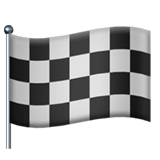

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [31]:
# delete NO RUN
for tt in tsk:
    tt['doctype'] = 'Task'
    tt['parent_task'] = ''
    conn.update(tt)
    conn.delete('Task', tt['name'])

###

In [217]:
# tsk[1]

In [220]:
# for t in tsk:
#     conn.delete('Task', t['name'])

In [218]:
# conn.delete('Task', 'e38sn3pg90')

In [205]:
# for t in tsk:
#     print(t['name'])
#     conn.delete('Task', t['name'])

In [188]:
# tsk[0]['doctype'] = 'Task'
# tsk[0]['depends_on'] = []
# conn.update(tsk[0])

In [206]:
# conn.get_doc('Task', 'e38p1tg5gg')

In [190]:
# conn.delete('Task', 'e38p1tg5gg')

In [165]:
# conn.get_doc('Task', 'lia3u8u03v')

In [161]:
# for t in tsk:
#     conn.delete('Task', t['name'])

## timesheet import with google sheet

#### process flow

In [1]:
# handle sheet file
    # for each row of sheets
        # handle row data
            # if row is empty
                # skip this row
            # if col_B == "P"
                # handle as parent task
                # if col_A is not empty (parent task is created)
                    # handle update parent task if any changes (compare hash)
                # else
                    # handle as new parent task
            # else
                # handle as task with timesheet
                # if col_A is not empty (timesheet is created)
                    # handle update timesheet if any changes (compare hash)
                # else
                    # handle as new timesheet
    # endfor
    # handle update col_A data of sheets
        # for each row of col_A array above
            # update batch of col_A in sheet
    # end of function

#### problems

In [ ]:
# 1. col_A: can be duplicate (user copy and paste with new row)
# 2. col_A: 
# 3.
# 4.

In [5]:
from util.google_sheet import GGSheet

In [6]:
EXCEL_TASK_PRIORITY = {
    "": "Medium",
    "1_Urgen": "Urgent",
    "2_Important": "High",
    "3_Medium": "Medium",
    "4_Low": "Low",
}
EXCEL_TYPE_PARENT_TASK = {
    "": "Other",
    "0_Pre CO": "Pre Concept",
    "1_CO": "Concept",
    "2_BD": "Basic Design",
    "3_DD": "Design Development",
    "4_TD": "Tender Doc",
    "5_CD": "Construction",
    "6_AU": "Authorship",
    "7_Other": "Other",
}
EXCEL_TASK_STATUS = {
    "": "Open",
    "1_Open": "Open",
    "2_In progress": "In Progress",
    "3_Pending": "Pending",
    "4_Cancel": "Cancel",
    "5_Done": "Done",
    "6_Review": "Review",
}
EXCEL_TIME_SHEET_STATUS = {
    "": "Draft",
    "Open": "Draft",
    "In Progress": "Draft",
    "Pending": "Draft",
    "Review": "Draft",
    "Done": "Submitted",
    "Cancel": "Cancelled",
}
EXCEL_TIME_SHEET_DOC_STATUS = {
    "": 0,
    "Draft": 0,
    "Submitted": 1,
    "Cancelled": 2,
}

In [7]:
row_of_date = 3
row_start   = 5
row_end     = 1200
# company     = "ACONS"

In [8]:
# url_file="https://docs.google.com/spreadsheets/d/12bDZbCnJVkFTJTeMBmgsrAEejVKQCXa11M951ylOQVw/edit#gid=1885142845"
# worksheet_name="BAP"

In [9]:
# url_file = "https://docs.google.com/spreadsheets/d/1rgen0jYUoAzHRelVi6c2ATJs3IzYPD20wMcT63inKoI/edit#gid=996503932"
# worksheet_name="T2"

In [10]:
# ggSheet = GGSheet(url_file, worksheet_name)

In [11]:
# def mapping_row_with_attr(row_data):
#     attrs = {}
#     # no need anymore
#     attrs["import_key"]          = row_data["A"] if "A" in row_data else ""
#     # import_key based on
#     # task
#     # new_key = f"{payload.expected_start_date};{payload.expected_end_date};{payload.new_end_date}"
#     # new_hash_key = hash_str_8_dig(new_key)
#     # prev_hash_key, _, __ = split_str_get_key(input_data=payload.prev_hash_key, char_split = "--")
#     # timesheet
#     # new_key = f"{project_code};{parent_task};{employee_name};{progress};{activity_code};{task};{excel_task_status};{date_string}"
#     # new_hash_key = hash_str_8_dig(new_key)
#     # A_column_key = f"{new_hash_key}--{task_doc}--{new_time_sheet_doc.name}"
#     # prev_hash_key, task_id, time_sheet_id = split_str_get_key(input_data=cell["A"], char_split="--")
    
#     attrs["row_type"]            = row_data["B"] if "B" in row_data else ""
#     attrs["project_code"]        = row_data["C"] if "C" in row_data else ""
#     attrs["project_name"]        = row_data["D"] if "D" in row_data else ""

#     attrs["expected_start_date"] = parser.parse(row_data["E"]) if "E" in row_data and row_data["E"] != "" else None
#     attrs["expected_end_date"]   = parser.parse(row_data["F"]) if "F" in row_data and row_data["F"] != "" else None
#     attrs["new_end_date"]        = parser.parse(row_data["G"]) if "G" in row_data and row_data["G"] != "" else None
#     attrs["phase_name"]          = EXCEL_TYPE_PARENT_TASK[row_data["H"] if "H" in row_data else ""]
#     # attrs["phase_name"           = EXCEL_TYPE_PARENT_TASK[row_data["H"] if "H" in row_data else ""]
#     # expected_time = float(cell["I"]) if "I" in cell and cell["I"] != "" else 0.0
#     attrs["expected_time"]       = float(row_data["I"]) if "I" in row_data and row_data["I"] != "" else 0.0
#     # col_J: real time (sum)
#     attrs["task_priority"]       = EXCEL_TASK_PRIORITY[row_data["K"] if "K" in row_data else ""]
#     attrs["progress"]            = row_data["L"].replace("%", "") if "L" in row_data else ""
#     attrs["employee_name"]       = row_data["M"] if "M" in row_data else ""
#     attrs["activity_code"]       = row_data["N"] if "N" in row_data else ""
#     if attrs["activity_code"] == "":
#         attrs["activity_code"] = "0000"
#     attrs["task"]                = row_data["O"] if "O" in row_data else ""
#     attrs["subject"]             = row_data["O"] if "O" in row_data else ""
#     if attrs["subject"] == "":
#         attrs["subject"] = "Other"
#     attrs["excel_task_status"]   = EXCEL_TASK_STATUS[row_data["P"] if "P" in row_data else ""]
#     attrs["task_status"]         = EXCEL_TASK_STATUS[row_data["P"] if "P" in row_data else ""]
#     # self.task_number = num
    
#     return attrs

In [12]:
# def mapping_row_with_time_log(row_data, row_date_header):
#     new_date = {}
#     date_string = ""
#     for column, value in row_data.items():
#         if column in row_date_header and value != None and value != "":
#             date = parser.parse(row_date_header[column])
#             new_date[date] = value
#             date_string = date_string + column + "-" + value + ";"
#     return new_date, date_string

In [13]:
# def hash_str_8_dig(raw_str):
#     encode = hashlib.sha1(raw_str.encode("utf-8")).hexdigest()
#     hash_obj = int(encode, 16) % (10 ** 8)
#     return str(hash_obj)

In [14]:
# cheap_hash = lambda input: hashlib.md5(input.encode("utf-8")).hexdigest()[:8]

In [15]:
# cheap_hash("pandion.vn")

In [16]:
# for caching
# project_doc_list = {}
# task_doc_list = {}
# employee_doc_list = {}
# timesheet_doc_list = {}

# for update sheet
# update_records = {}

In [17]:
# def is_row_empty(row_attrs):
#     if row_attrs['project_code'] == "":
#         return True
#     return False

In [18]:
# def is_row_timesheet_empty(row_attrs):
#     if row_attrs['project_code'] == "":
#         return True
#     return False

In [19]:
# def is_time_log_row_empty(row_time_logs):
#     return True

In [20]:
# def create_task():
#     pass

In [21]:
# def update_task():
#     pass

In [22]:
# def create_timesheet():
#     pass

In [23]:
# def update_timesheet():
#     pass

In [24]:
# def get_project_doc(doc_name):
#     # return if cached else get db & cache
#     if project_doc_list.get(doc_name):
#         return project_doc_list[doc_name]
#     else:
#         doc = conn.get_doc('Project', doc_name)
#         if doc:
#             project_doc_list[doc_name] = doc
#             return doc

#     return None

In [25]:
# def get_employee_doc(doc_name):
#     # return if cached else get db & cache
#     if employee_doc_list.get(doc_name):
#         return employee_doc_list[doc_name]
#     else:
#         doc = conn.get_doc('Employee', doc_name)
#         if doc:
#             employee_doc_list[doc_name] = doc
#             return doc
#     return None

In [26]:
# def get_employee_doc_by_name(employee_name):
    
#     doc_name = conn.get_value("Employee", 
#                               ["name"],
#                               [["employee_name", "=", employee_name]])
#     print(f"employee: {doc_name}")
#     if doc_name:
#         return get_employee_doc(doc_name['name'])
        
#     return None

In [27]:
# def get_task(doc_name):
#     # return if cached else get db & cache
#     if task_doc_list.get(doc_name):
#         return task_doc_list[doc_name]
#     else:
#         doc = conn.get_doc('Task', doc_name)
#         if doc:
#             task_doc_list[doc_name] = doc
#             return doc
#     return None

In [47]:
# def get_task_doc_by_fields(subject, project_code, phase_name, is_group=0, parent_task=""):

#     filters = [["subject", "=", subject],
#                ["project", "=", project_code], 
#                ["type", "=", phase_name],
#                ["is_group", "=", is_group]]
#     if parent_task != "":
#         filters.append(["parent_task", "=", parent_task])
    
#     doc_name = conn.get_value("Task", ["name"], filters)
#     if doc_name:
#         # print(f"doc_name existed")
#         return get_task(doc_name["name"])
#     return None

In [29]:
# def get_timesheet(doc_name):
#     # return if cached else get db & cache
#     if timesheet_doc_list.get(doc_name):
#         return timesheet_doc_list[doc_name]
#     else:
#         doc = conn.get_doc('Timesheet', doc_name)
#         if doc:
#             timesheet_doc_list[doc_name] = doc
#             return doc
#     return None
#     pass

In [30]:
# def create_task(payload):
#     return conn.insert(payload)
#     # pass

In [31]:
# def update_task(payload):
#     pass

In [32]:
# def create_timesheet(payload):
#     conn.insert(payload)

In [33]:
# def update_timesheet(name, payload):
#     pass

In [34]:
# import_key for task: task_id||
def handle_timesheet_row_with_parent_task(idx, row_data, row_attrs, row_date_header, company):

    # print(f"  Handle parent task at row: {idx}\n"
    #       f"  import_key: {row_attrs['import_key']}\n"
    #       f"  project_code: {row_attrs['project_code']}\n"
    #       f"  phase_name: {row_attrs['phase_name']}\n"
    #       f"  subject: {row_attrs['subject']}\n"
    #       f"  task: {row_attrs['task']}")
    task_doc = get_task_doc_by_fields(row_attrs['subject'], row_attrs['project_code'], row_attrs['phase_name'], 1)

    if task_doc:
        return task_doc
    else:
        # create new
        payload = {}
        payload["doctype"] = "Task"
        payload["subject"] = row_attrs["subject"]
        payload["project"] = row_attrs["project_code"]
        payload["type"] = row_attrs["phase_name"]
        payload["is_group"] = 1
        print(f"{payload}")
        return create_task(payload)

In [49]:
# import_key for task: timesheet_id||
def handle_timesheet_row_as_task(idx, row_data, row_attrs, row_date_header, 
                                 parent_task_row, parent_task_doc, company):
    time_logs_date, time_logsdate_string = mapping_row_with_time_log(row_data, row_date_header)
    
    # print(f"  Handle task at row: {idx}\n"
    #       f"  import_key: {row_attrs['import_key']}\n"
    #       f"  project_code: {row_attrs['project_code']}\n"
    #       f"  phase_name: {row_attrs['phase_name']}\n"
    #       # f"  subject: {row_attrs['subject']}\n"
    #       f"  employee_name: {row_attrs['employee_name']}\n"
    #       f"  task: {row_attrs['task']}\n"
    #       f"  parent task row: {parent_task_row}\n"
    #       f"  parent task doc: {parent_task_doc}\n"
    #       f"  time_logs: {time_logs_date}")

    doc_name = conn.get_value("Timesheet", 
                              ["name"],
                              [["employee", "=", row_attrs['employee_code']],
                               ["parent_project", "=", row_attrs['project_code']],
                               ["custom_task", "=", row_attrs['task']],
                               ["custom_phase", "=", row_attrs['phase_name']],])

    if doc_name:
        print(f"Timesheet doc_name existed {doc_name}")
        
        # existed
        payload = {}
        payload["doctype"] = "Timesheet"
        payload["name"] = doc_name["name"]
        payload["employee"] = row_attrs["employee_code"]
        payload["customer"] = company
        payload["parent_project"] = row_attrs["project_code"]
        payload["custom_task"] = row_attrs["task"]
        payload["custom_phase"] = row_attrs["phase_name"]
        # payload["start_date"] = row_attrs["phase_name"]
        time_logs = []
        for date, hrs in time_logs_date.items():
            # check task here for update or new
            task_doc = get_task_doc_by_fields(row_attrs['subject'], 
                                              row_attrs['project_code'], 
                                              row_attrs['phase_name'], 0, parent_task_doc['name'])
            # task_doc_name = conn.get_value("Task", 
            #                               ["name"],
            #                               [["subject", "=", row_attrs['subject']],
            #                                ["project", "=", row_attrs['project_code']], 
            #                                ["type", "=", row_attrs['phase_name']],
            #                                ["is_group", "=", 0], 
            #                                ["parent_task", "=", parent_task_doc['task_doc']['name']]])
            # if task_doc_name:
            #     # print("task is existed")
            #     task_doc = get_task(task_doc_name['name'])
            # else:
            if task_doc is None:
                print("task is not exists")
                # new task for timelogs
                task_payload = {}
                task_payload["doctype"] = "Task"
                task_payload["subject"] = row_attrs["subject"]
                task_payload["project"] = row_attrs["project_code"]
                task_payload["type"] = row_attrs["phase_name"]
                task_payload["is_group"] = 0
                task_payload["parent_task"] = parent_task_doc['task_doc']['name']
                # print(f"{task_payload}")
                task_doc = create_task(task_payload)
                # print(f"new task doc: {task_doc}")

            if task_doc is None:
                print("fixme")
                continue
                
            time_logs.append({
                    "activity_type": row_attrs['activity_code'],
                    "from_time": date.strftime("%Y-%m-%d"),
                    "hours": float(hrs),
                    "project": row_attrs['project_code'],
                    "task": task_doc['name'],
                    # "completed": excel_task_status == "Done",
                })
        payload["time_logs"] = time_logs
        # payload["is_group"] = 1
        print(f"{payload}")
        conn.update(payload)
        # pass
    else:
        # create new
        payload = {}
        payload["doctype"] = "Timesheet"
        payload["employee"] = row_attrs["employee_code"]
        payload["parent_project"] = row_attrs["project_code"]
        payload["customer"] = company
        payload["custom_task"] = row_attrs["task"]
        payload["custom_phase"] = row_attrs["phase_name"]
        # payload["start_date"] = row_attrs["phase_name"]

        time_logs = []
        for date, hrs in time_logs_date.items():
            # check task here for update or new
            task_doc = get_task_doc_by_fields(row_attrs['subject'], 
                                              row_attrs['project_code'], 
                                              row_attrs['phase_name'], 0, parent_task_doc['name'])
            if task_doc is None:
                print("task is not exists")
                # new task for timelogs
                task_payload = {}
                task_payload["doctype"] = "Task"
                task_payload["subject"] = row_attrs["subject"]
                task_payload["project"] = row_attrs["project_code"]
                task_payload["type"] = row_attrs["phase_name"]
                task_payload["is_group"] = 0
                task_payload["parent_task"] = parent_task_doc['task_doc']['name']
                # print(f"{task_payload}")
                task_doc = create_task(task_payload)
                # print(f"new task doc: {task_doc}")

            if task_doc is None:
                print("fixme")
                continue
            
            time_logs.append({
                    "activity_type": row_attrs['activity_code'],
                    "from_time": date.strftime("%Y-%m-%d"),
                    "hours": float(hrs),
                    "project": row_attrs['project_code'],
                    "task": task_doc['name'],
                    # "completed": excel_task_status == "Done",
                })
        payload["time_logs"] = time_logs
        # payload["is_group"] = 1
        print(f"{payload}")
        create_timesheet(payload)

    return True

In [36]:
current_parent_task_row = 0
current_parent_task_doc = {}

In [37]:
# if row is empty
    # skip this row
# if col_B == "P"
    # handle as parent task
    # if col_A is not empty (parent task is created)
        # handle update parent task if any changes (compare hash)
    # else
        # handle as new parent task
# else
    # handle as task with timesheet
    # if col_A is not empty (timesheet is created)
        # handle update timesheet if any changes (compare hash)
    # else
        # handle as new timesheet
def handle_timesheet_row(idx, row_data, row_date_header, company):
    global current_parent_task_row
    global current_parent_task_doc
    row_attrs = mapping_row_with_attr(row_data)
    # NO project code
    if is_row_empty(row_attrs):
        return False

    # project code is not found ?
    print(f"Project code: {row_attrs['project_code']}")
    project_doc = get_project(row_attrs['project_code'])
    if project_doc is None:
        print(f"Project is not found: {row_attrs['project_code']}")
        return False
    
    if row_attrs['row_type'] == "P":
        # handle as parent task
        # if row_attrs['project_code'] in ["HR01_ACO.00"]:
        #     return
        ret = handle_timesheet_row_with_parent_task(idx, row_data, row_attrs, row_date_header, company)
        current_parent_task_row = idx
        current_parent_task_doc = ret
        # {
        #     # 'row_data': row_data,
        #     # 'row_attrs': row_attrs,
        #     'task_doc': ret
        # }
        return True
    else:
        # employee name is not found?
        print(f"Employee name: {row_attrs['employee_name']}")
        employee_doc = get_employee_doc_by_name(row_attrs['employee_name'])
        if employee_doc is None:
            print(f"Employee is not found: {row_attrs['employee_name']}")
            return False
        else:
            print(f"Employee code: {employee_doc['name']}")
            row_attrs['employee_code'] = employee_doc['name']
        # return False
        # handle as task with timesheet
        ret = handle_timesheet_row_as_task(idx, row_data, row_attrs, row_date_header, 
                                            current_parent_task_row, current_parent_task_doc, company)
        return ret
        

In [38]:
def handle_timesheet_sheet():
    try:
        # row_date_header = await get_row_date_header()
        # all_records = await ggSheet.get_all_row_values()
        
        current_parent_task_row = 0
        for idx, row_data in enumerate(all_records):
            if idx >= row_start and idx <= row_end:
                print(f"idx: {idx}")
                # print(row_data)
                handle_timesheet_row(idx, row_data, row_date_header, company)
                # break
    except Exception as err:
        print(f"Handle timesheet {worksheet_name} failed with: {err}")

In [39]:
url_file="https://docs.google.com/spreadsheets/d/12bDZbCnJVkFTJTeMBmgsrAEejVKQCXa11M951ylOQVw/edit#gid=1885142845"
worksheet_name="BAP"

In [40]:
ggSheet = GGSheet(url_file, worksheet_name)

In [41]:
row_date_header = await ggSheet.get_row_date_header(row_of_date)

In [42]:
all_records = await ggSheet.get_all_row_values()

In [43]:
len(employee_doc_list)

0

In [44]:
len(task_doc_list)

0

In [45]:
len(project_doc_list)

0

## BAP Team

In [50]:
company     = "BAP"
handle_timesheet_sheet()

idx: 5
Project code: HR01_ACO.00
idx: 6
Project code: HR01_ACO.00
Employee name: Nhật Phạm Hoàng
employee: {'name': 'HR-EMP-00007'}
Employee code: HR-EMP-00007
Timesheet doc_name existed {'name': 'TS-23-05-24-05061_HR-EMP-00007'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05061_HR-EMP-00007', 'employee': 'HR-EMP-00007', 'customer': 'BAP', 'parent_project': 'HR01_ACO.00', 'custom_task': 'Nghỉ lễ', 'custom_phase': 'Other', 'time_logs': [{'activity_type': '2000', 'from_time': '2024-04-27', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': '7iks43j1g1'}, {'activity_type': '2000', 'from_time': '2024-04-29', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': '7iks43j1g1'}, {'activity_type': '2000', 'from_time': '2024-04-30', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': '7iks43j1g1'}, {'activity_type': '2000', 'from_time': '2024-05-01', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': '7iks43j1g1'}]}
idx: 7
Project code: HR01_ACO.00
Employee name: Huyền Bùi Thị Thanh
employee: {'name': 'HR-EM

## TEAM_2

In [51]:
url_file = "https://docs.google.com/spreadsheets/d/1rgen0jYUoAzHRelVi6c2ATJs3IzYPD20wMcT63inKoI/edit#gid=996503932"
worksheet_name="T2"
company="ACO"

In [52]:
await ggSheet.set_worksheet(url_file, worksheet_name)

In [53]:
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [54]:
handle_timesheet_sheet()

idx: 5
Project code: P33422_HTP.00
idx: 6
Project code: P33422_HTP.00
Employee name: Bình Trịnh Thanh
employee: {'name': 'HR-EMP-00020'}
Employee code: HR-EMP-00020
Timesheet doc_name existed {'name': 'TS-23-05-24-05226_HR-EMP-00020'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05226_HR-EMP-00020', 'employee': 'HR-EMP-00020', 'customer': 'ACO', 'parent_project': 'P33422_HTP.00', 'custom_task': 'Thuyết minh TKTC', 'custom_phase': 'Construction', 'time_logs': []}
idx: 7
Project code: P33422_HTP.00
Employee name: Huy Phan Trịnh Hoàng
employee: {'name': 'HR-EMP-00069'}
Employee code: HR-EMP-00069
Timesheet doc_name existed {'name': 'TS-23-05-24-05227_HR-EMP-00069'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05227_HR-EMP-00069', 'employee': 'HR-EMP-00069', 'customer': 'ACO', 'parent_project': 'P33422_HTP.00', 'custom_task': 'Thuyết minh TKTC', 'custom_phase': 'Construction', 'time_logs': []}
idx: 8
Project code: P33422_HTP.00
Employee name: Bình Trịnh Thanh
employee: {'name': 'HR-EMP-0

## TEAM3

In [55]:
# team_3
# url_file="https://docs.google.com/spreadsheets/d/1hO5er83L8qU6UITbsjacZg_A6SPW8MuFRBEfwQd1dys/edit#gid=370020233"
# copied
url_file = "https://docs.google.com/spreadsheets/d/1LLKxyhIAbjMl8MXREZBGyH7r8puEtQATc5AiQLOIbh8/edit#gid=370020233"
worksheet_name="T3"
company="ACO"

In [56]:
await ggSheet.set_worksheet(url_file, worksheet_name)

In [57]:
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [58]:
handle_timesheet_sheet()

idx: 5
Project code: P000_ACO.00
idx: 6
Project code: P000_ACO.00
Employee name: Trung Đỗ Thành
employee: {'name': 'HR-EMP-00041'}
Employee code: HR-EMP-00041
Timesheet doc_name existed {'name': 'TS-23-05-24-05592_HR-EMP-00041'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05592_HR-EMP-00041', 'employee': 'HR-EMP-00041', 'customer': 'ACO', 'parent_project': 'P000_ACO.00', 'custom_task': 'Họp nội bộ', 'custom_phase': 'Other', 'time_logs': [{'activity_type': '2000', 'from_time': '2024-05-06', 'hours': 2.0, 'project': 'P000_ACO.00', 'task': 'd2946kmc0l'}]}
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
idx: 13
idx: 14
idx: 15
Project code: HR01_ACO.00
idx: 16
Project code: HR01_ACO.00
Employee name: Trung Đỗ Thành
employee: {'name': 'HR-EMP-00041'}
Employee code: HR-EMP-00041
Timesheet doc_name existed {'name': 'TS-23-05-24-05593_HR-EMP-00041'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05593_HR-EMP-00041', 'employee': 'HR-EMP-00041', 'customer': 'ACO', 'parent_project': 'HR01_ACO.00', 

## TEAM 4

In [59]:
# team_4
# url_file="https://docs.google.com/spreadsheets/d/1p1vffmF2H-rOSdrNjdqMAXYTFlf9HkBX7FJjk2l4OwA/edit#gid=1885142845"
# copied
url_file="https://docs.google.com/spreadsheets/d/11TQi-pF13BGS2LkrOHzO1EK-zAiZPw_Vop61d69oMFo/edit#gid=1885142845"
worksheet_name="T4"
company="ACO"

In [60]:
await ggSheet.set_worksheet(url_file, worksheet_name)

In [61]:
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [62]:
handle_timesheet_sheet()

idx: 5
Project code: HR01_ACO.00
idx: 6
Project code: HR01_ACO.00
Employee name: An Nguyễn Bình
employee: {'name': 'HR-EMP-00003'}
Employee code: HR-EMP-00003
Timesheet doc_name existed {'name': 'TS-23-05-24-05801_HR-EMP-00003'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05801_HR-EMP-00003', 'employee': 'HR-EMP-00003', 'customer': 'ACO', 'parent_project': 'HR01_ACO.00', 'custom_task': 'Nghỉ lễ giỗ tổ', 'custom_phase': 'Construction', 'time_logs': [{'activity_type': '4001', 'from_time': '2024-04-18', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': 'd62mj6kmal'}]}
idx: 7
Project code: HR01_ACO.00
Employee name: Son Trần Thị Minh
employee: {'name': 'HR-EMP-00005'}
Employee code: HR-EMP-00005
Timesheet doc_name existed {'name': 'TS-23-05-24-05802_HR-EMP-00005'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-05802_HR-EMP-00005', 'employee': 'HR-EMP-00005', 'customer': 'ACO', 'parent_project': 'HR01_ACO.00', 'custom_task': 'Nghỉ lễ giỗ tổ', 'custom_phase': 'Construction', 'time_logs': [{'a

## TEAM 5

In [63]:
# team_5
# url_file="https://docs.google.com/spreadsheets/d/1vTy7Qout9WoeZa31lHLQUw6CZecjEJOKUQlDIAmk1vk/edit#gid=1742134070"
# copied
url_file="https://docs.google.com/spreadsheets/d/125OUpshHBj577ppiOUO_n73ZtgKDBBqLpmR0qST-IZA/edit#gid=1742134070"
worksheet_name="T5"
company="ACO"

In [64]:
await ggSheet.set_worksheet(url_file, worksheet_name)

In [65]:
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [66]:
handle_timesheet_sheet()

idx: 5
Project code: P39423_KNCR.00
idx: 6
Project code: P39423_KNCR.00
Employee name: 
employee: {}
Employee is not found: 
idx: 7
Project code: P39423_KNCR.00
Employee name: Thành Hồ Đức Thiện
employee: {'name': 'HR-EMP-00008'}
Employee code: HR-EMP-00008
Timesheet doc_name existed {'name': 'TS-23-05-24-06036_HR-EMP-00008'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-06036_HR-EMP-00008', 'employee': 'HR-EMP-00008', 'customer': 'ACO', 'parent_project': 'P39423_KNCR.00', 'custom_task': 'Cập nhật phản hồi TKCS', 'custom_phase': 'Other', 'time_logs': [{'activity_type': '2303', 'from_time': '2024-04-01', 'hours': 8.0, 'project': 'P39423_KNCR.00', 'task': 'dco8m4aj1i'}, {'activity_type': '2303', 'from_time': '2024-04-02', 'hours': 8.0, 'project': 'P39423_KNCR.00', 'task': 'dco8m4aj1i'}, {'activity_type': '2303', 'from_time': '2024-04-03', 'hours': 8.0, 'project': 'P39423_KNCR.00', 'task': 'dco8m4aj1i'}, {'activity_type': '2303', 'from_time': '2024-04-04', 'hours': 8.0, 'project': 'P39423

## TEAM 6

In [67]:
# team_6
# url_file="https://docs.google.com/spreadsheets/d/14m-Sk89NxBeh9pnqrtYr-Vdi92INzIFF1uxO7lpTDuk/edit#gid=1175515436"
# copied
url_file="https://docs.google.com/spreadsheets/d/1CgHfrscwLZlU7gjk1IBGARlxEEsFML9YMiuEsaA9FWE/edit#gid=994132924"
worksheet_name="T6"
company="ACO"

In [68]:
await ggSheet.set_worksheet(url_file, worksheet_name)
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [69]:
handle_timesheet_sheet()

idx: 5
Project code: HR01_ACO.00
idx: 6
Project code: HR01_ACO.00
Employee name: Thiện Lê Phú
employee: {'name': 'HR-EMP-00043'}
Employee code: HR-EMP-00043
Timesheet doc_name existed {'name': 'TS-23-05-24-06074_HR-EMP-00043'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-06074_HR-EMP-00043', 'employee': 'HR-EMP-00043', 'customer': 'ACO', 'parent_project': 'HR01_ACO.00', 'custom_task': '', 'custom_phase': 'Other', 'time_logs': [{'activity_type': '4001', 'from_time': '2024-04-18', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': 'bia0dlhuhn'}, {'activity_type': '4001', 'from_time': '2024-04-27', 'hours': 4.0, 'project': 'HR01_ACO.00', 'task': 'bia0dlhuhn'}, {'activity_type': '4001', 'from_time': '2024-04-29', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': 'bia0dlhuhn'}, {'activity_type': '4001', 'from_time': '2024-04-30', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': 'bia0dlhuhn'}, {'activity_type': '4001', 'from_time': '2024-05-01', 'hours': 8.0, 'project': 'HR01_ACO.00', 'task': 'bi

## TEAM CIVIL

In [70]:
# team_civil
# url_file="https://docs.google.com/spreadsheets/d/1qiVQptv2NK08Nr44ZapI8QTEHoDf1DhSpN0jkEe9_Ks/edit#gid=903792263"
# copied
url_file=""
worksheet_name="CIVIL"
company="ACO"

In [ ]:
await ggSheet.set_worksheet(url_file, worksheet_name)
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [ ]:
handle_timesheet_sheet()

## TEAM RND

In [71]:
# team_rnd
# url_file="https://docs.google.com/spreadsheets/d/15JPQLVqA_WDLmK00AsCnYrv1xqGzWwV9xbung_JDBmU/edit#gid=1885142845"
# copied
url_file="https://docs.google.com/spreadsheets/d/1EhlTU0LKzv-OsngOaZ9rXpzOPXmAureMjHrRo2OecTw/edit#gid=1885142845"
worksheet_name="RnD"
company="ACO"

In [72]:
await ggSheet.set_worksheet(url_file, worksheet_name)
row_date_header = await ggSheet.get_row_date_header(row_of_date)
all_records = await ggSheet.get_all_row_values()

In [73]:
handle_timesheet_sheet()

idx: 5
Project code: P000_ACO.00
idx: 6
Project code: P000_ACO.00
Employee name: Việt Nguyễn Hồng
employee: {'name': 'HR-EMP-00040'}
Employee code: HR-EMP-00040
Timesheet doc_name existed {'name': 'TS-23-05-24-06162_HR-EMP-00040'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-06162_HR-EMP-00040', 'employee': 'HR-EMP-00040', 'customer': 'ACO', 'parent_project': 'P000_ACO.00', 'custom_task': 'Gernal Task', 'custom_phase': 'Other', 'time_logs': [{'activity_type': '2000', 'from_time': '2024-05-20', 'hours': 2.0, 'project': 'P000_ACO.00', 'task': 'diit0en9af'}]}
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
Project code: I00124_RSCI.00
idx: 13
Project code: I00124_RSCI.00
Employee name: Sokkheang Chan
employee: {'name': 'HR-EMP-00050'}
Employee code: HR-EMP-00050
Timesheet doc_name existed {'name': 'TS-23-05-24-06163_HR-EMP-00050'}
{'doctype': 'Timesheet', 'name': 'TS-23-05-24-06163_HR-EMP-00050', 'employee': 'HR-EMP-00050', 'customer': 'ACO', 'parent_project': 'I00124_RSCI.00', 'custom_task

In [ ]:







# team_bap
# url_file="https://docs.google.com/spreadsheets/d/11y58PE9RM16JozFR8yT-oV3K4etIsp2oFmiCsYVaydk/edit#gid=1885142845"
# copied
url_file="https://docs.google.com/spreadsheets/d/12bDZbCnJVkFTJTeMBmgsrAEejVKQCXa11M951ylOQVw/edit#gid=1885142845"
worksheet_name="BAP"
company="BAP"

